In [1]:
%matplotlib notebook
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.mri_viewer import MRIViewer
from utils.data_utils import im_path_to_arr
from utils.config import Config
from utils.dice_score import dice_score
from utils.data_utils import resize_data_to_original_size
from utils.dataset_v3 import load_data_tcga
from models.fcn_concat import FCN_Concat
from models.fcn_concat_v2 import FCN_Concat_v2

In [2]:
config_path = 'config_files/fcn_train_concat_2017_v692_bmi.cfg'
config = Config(config_path)
model = FCN_Concat_v2(config)

In [3]:
# between 1 and TODO
patient_id = 2

In [4]:
ex_path = '/local-scratch/marcthib_scratch/tcga2017/val/'
patient = os.listdir(ex_path)[patient_id - 1]
patient_path = os.path.join(ex_path, patient)

patient_data = load_data_tcga(patient_path.encode("utf-8"), True, [1]*4)

t1pre = patient_data[0][:, :, :, 0]
t1post = patient_data[0][:, :, :, 1]
t2 = patient_data[0][:, :, :, 2]
flair = patient_data[0][:, :, :, 3]

label = patient_data[1]

In [5]:
patient_path

'/local-scratch/marcthib_scratch/tcga2017/val/TCGA-CS-4944'

In [6]:
patient_path = patient_path.encode('utf-8')
saver = tf.train.Saver()
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
with tf.Session() as sess:
    saver.restore(sess, config.ckpt_path)
    pred = model.run_pred_single_example_v3(sess, patient_path)
    pred[pred == 3] = 4
patient_path = patient_path.decode('utf-8')

INFO:tensorflow:Restoring parameters from ckpt/fcn_brats_concat_2017_v692_bmi.ckpt


### Visualize modalities

<IPython.core.display.Javascript object>


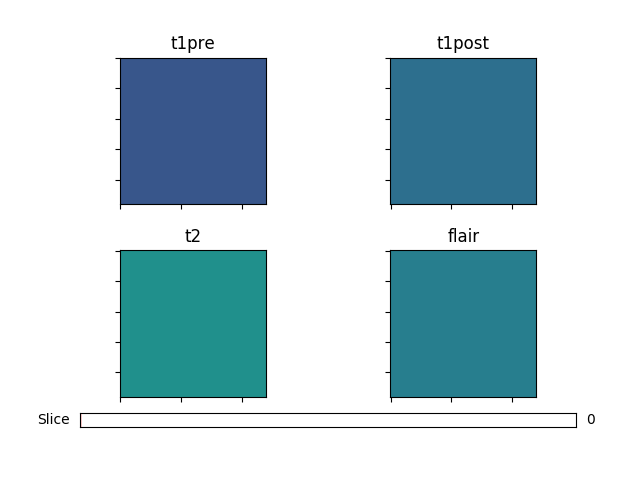

In [7]:
MRIViewer(t1pre, t1post, t2, flair, cmap=None, 
          title1='t1pre', title2='t1post', title3='t2', title4='flair')

In [9]:
np.unique(pred)

array([0., 1., 2.])

### Visualize predictions

In [10]:
def get_dice_scores(p, y):
    dice_whole = dice_score(y, pred)
    fpred_core = (p == 1) + (p == 4)
    fy_core = (y == 1) + (y == 4)
    dice_core = dice_score(fy_core, fpred_core)
    fpred_enhancing = p == 4
    fy_enhancing = y == 4
    dice_enhancing = dice_score(fy_enhancing, fpred_enhancing)
    print('whole: %f ... core: %f ... enhancing: %f ...'%(dice_whole, dice_core, dice_enhancing))
get_dice_scores(pred, label)

whole: 0.421877 ... core: 0.079436 ... enhancing: 1.000000 ...


<IPython.core.display.Javascript object>


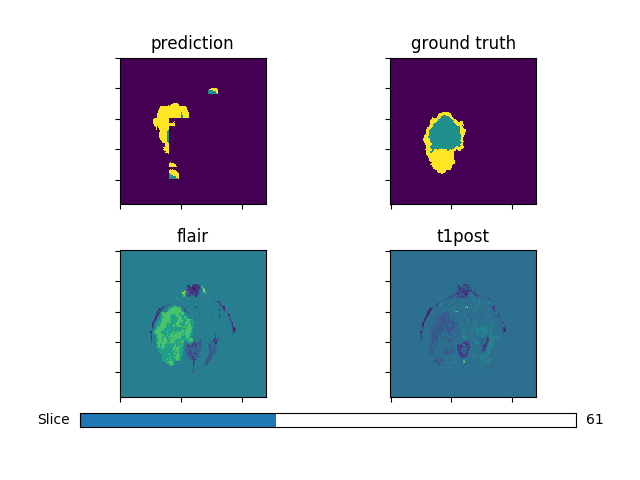

In [11]:
flair_pred = np.array(flair)
flair_pred[pred == 1] = 1000
flair_pred[pred == 2] = 2000
flair_pred[pred == 4] = 4000
flair_label = np.array(flair)
flair_label[label == 1] = 1000
flair_label[label == 2] = 2000
flair_label[label == 4] = 4000
MRIViewer(flair_pred, flair_label, flair, t1post, cmap=None, 
          title1='prediction', title2='ground truth', title3='flair', title4='t1post')

In [12]:
print(np.count_nonzero(label == 1), np.count_nonzero(pred == 1))
print(np.count_nonzero(label == 2), np.count_nonzero(pred == 2))
print(np.count_nonzero(label == 4), np.count_nonzero(pred == 4))

77985 5957
117448 84679
0 0


### legend:
- yellow = 2000 = EDEMA
- green = 4000 = ENHANCING
- blue = 1000 = NECROSYS